In [84]:
import pandas as pd
import nltk
import regex as re
import string
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, \
                                 classification_report, accuracy_score, precision_score, plot_confusion_matrix

from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline as imbpipe

import time
RANDOM_SEED = 85213

In [2]:
df = pd.read_csv('./data/tweets.csv')

# EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [4]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [5]:
df.is_there_an_emotion_directed_at_a_brand_or_product.value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

This shows a big imbalance in the number of positive and negative sentiments, and also shows the majority of it having no opinion.<br />
We're joining the 'I cant't tell' column with the 'No emotion' one.

In [6]:
df['is_there_an_emotion_directed_at_a_brand_or_product'] = df['is_there_an_emotion_directed_at_a_brand_or_product'].apply(lambda x: 'No emotion toward brand or product' if  x == "I can't tell" else x)

In [7]:
df.emotion_in_tweet_is_directed_at.value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [8]:
df.isna().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

Getting rid of the one instance of empty tweet:

In [9]:
df.dropna(subset=['tweet_text'], inplace=True)

Getting rid of duplicates:

In [10]:
df.duplicated().sum()

22

In [11]:
df.drop_duplicates(inplace=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9070 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9070 non-null   object
 1   emotion_in_tweet_is_directed_at                     3282 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9070 non-null   object
dtypes: object(3)
memory usage: 283.4+ KB


Renaming columns for easier understanding:

In [13]:
df.rename(columns={'tweet_text': 'text', 'emotion_in_tweet_is_directed_at': 'product', 'is_there_an_emotion_directed_at_a_brand_or_product': 'target'}, inplace=True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9070 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     9070 non-null   object
 1   product  3282 non-null   object
 2   target   9070 non-null   object
dtypes: object(3)
memory usage: 283.4+ KB


Creating a length feature:

# Modeling

### Train-Test Split

In [62]:
X = df['text']
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_SEED, stratify=y)

In [63]:
df_train=pd.concat([X_train, y_train], axis=1)
df_test=pd.concat([X_test, y_test], axis=1)

### Functions for data-cleaning

In [64]:
def label(df):
    df['target'] = df['target'].map({'No emotion toward brand or product': 0,
                                     'Negative emotion': 1,
                                     'Positive emotion': 2,
                                     'I can\'t tell': 0})
    return df

In [65]:
def clean_function(df):
    df['text'] = df['text'].apply(lambda x: x.lower())
    df['text'] = df['text'].str.encode('ascii', 'ignore').str.decode('ascii')
    df['text'] = df['text'].apply(lambda x: re.sub(r'http\S+', '', x))
    df['text'] = df['text'].apply(lambda x: re.sub(r'@\S*', '', x))
    return df

In [66]:
def remove_non_ascii(text):
    return unidecode(unicode(text, encoding = "utf-8"))

In [67]:
def tokenize(df):
    df['text'] = df['text'].apply(lambda x: re.split("\W+",x) )
    return df

In [68]:
def remove_punctuation(df):
    df['text'] = df['text'].apply(lambda x: [''.join(letter for letter in word if letter not in string.punctuation) for word in x])
    df['text'] = df['text'].apply(lambda x: [word for word in x if word])
    return df

In [69]:
stopword = nltk.corpus.stopwords.words('english')
stopword.remove('not')
stopword.append('rt')
def remove_stopwords(df):
    df['text'] = df['text'].apply(lambda x: [word for word in x if word not in stopword])
    return df

In [70]:
def lem(df):
    df['text'] = df['text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x]).apply(lambda x: ' '.join(x))
    return df

In [71]:
def join_cleaned_data(df):
    df['text'] = df['text'].apply(lambda x: ' '.join(x))
    return df

### Creating data-cleaning pipeline

In [72]:
cleaning_pipeline = Pipeline(steps=[
    ('label', FunctionTransformer(label)),
    ('clean', FunctionTransformer(clean_function)),
    ('token', FunctionTransformer(tokenize)),
    ('remove_punctuation', FunctionTransformer(remove_punctuation)),
    ('remove_stopwords', FunctionTransformer(remove_stopwords)),
    ('join_cleaned_data', FunctionTransformer(join_cleaned_data))
])

In [73]:
df_train.head()

,text,target
4289,The Go Game Launches Do-It-Yourself iPhone Sca...,No emotion toward brand or product
1339,.@mention would like a data dashboard of what ...,No emotion toward brand or product
1862,@mention about to talk at #sxsw on mistakes bu...,Negative emotion
455,guess who drew a bigger crowd at #sxsw: @menti...,No emotion toward brand or product
5668,RT @mention Developers Learn About Mobile Acce...,No emotion toward brand or product


### Cleaning the data

In [74]:
df_train_clean = cleaning_pipeline.fit_transform(df_train)
df_test_clean = cleaning_pipeline.transform(df_test)

In [75]:
df_train_clean.head()

,text,target
4289,go game launches iphone scavenger hunts link v...,0
1339,would like data dashboard govt knows like cred...,0
1862,talk sxsw mistakes building netflix iphone app,1
455,guess drew bigger crowd sxsw chimp could work ...,0
5668,developers learn mobile accessibility sxsw and...,0


In [76]:
X_train_clean = df_train_clean['text']
y_train_clean = df_train_clean['target']

## Creating simple models with CV

In [77]:
mnb = Pipeline([('cv', CountVectorizer(lowercase=False)),
               ('mnb', MultinomialNB())])

lr = Pipeline([('Vectorizer', CountVectorizer(lowercase=False)),
               ('LogisticReg', LogisticRegression(max_iter=200, random_state=RANDOM_SEED))])

dtc = Pipeline([('Vectorizer', CountVectorizer(lowercase=False)),
               ('DecisionTree', DecisionTreeClassifier(random_state=RANDOM_SEED))])

rf = Pipeline([('Vectorizer', CountVectorizer(lowercase=False)),
               ('RandomFor', RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED))]) 

gbc = Pipeline([('Vectorizer', CountVectorizer(lowercase=False)),
               ('gradiendboosting', GradientBoostingClassifier(random_state=RANDOM_SEED))])

svc = Pipeline([('Vectorizer', CountVectorizer(lowercase=False)),
                ('SupportVec', SVC(random_state=RANDOM_SEED))])

In [78]:
models = [('MultiNomBa', mnb),
          ('LogisticReg', lr),
          ('DecTreeClass', dtc),
          ('RandomFor', rf),
          ('GradBoost', gbc),
          ('SupportVec', svc)]

In [85]:
def fit_models(models, X, y):
    '''
    Inputs a list of (name, model), X, y
    Fits data into models
    '''
    for name, model in models:
        model.fit(X, y)
    return None

In [86]:
display_labels = ['No Emotion', 
                  'Negative Emotion', 
                  'Positive Emotion']

def print_cm_with_labels(y_true, 
                         y_pred, 
                         display_labels):
    '''
    Takes the true values and predicted values of a classifier and 
    plots a confusion matrix (normalized by predictions) using 
    a list of given display labels.
    '''
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=display_labels)

    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax)
    ax.grid(False)
    disp.ax_.set_xticklabels(display_labels,rotation=45);

In [87]:
def cross_validate_models(models, X, y, cv=5, scoring='accuracy', cm=False):
    '''
    Input: Models (name, model), X, y
    Output: models scores (default='accuracy')
    if cm=True, print models confusion matrices
    '''
    fit_models(models, X_train_clean, y_train_clean)
    results = [(name, cross_validate(model, X_train_clean, y_train_clean, scoring=scoring, cv=cv)) for name, model, in models]
    scores = [(result[0], result[1]['test_score'].mean()) for result in results]
    if cm==True:
        for model in models:
             print_cm_with_labels(y_train_clean, model[1].predict(X_train_clean), display_labels)
    return scores

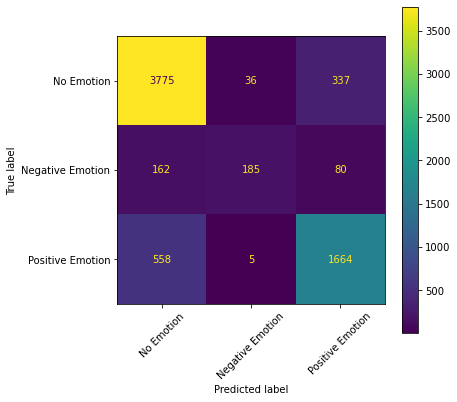

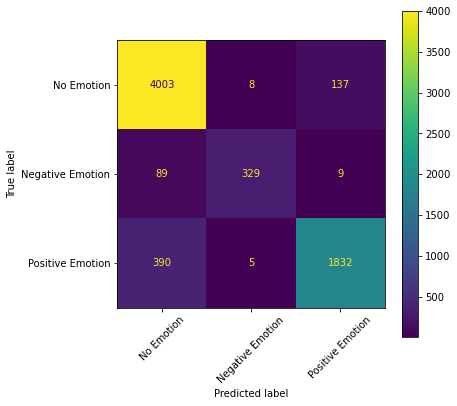

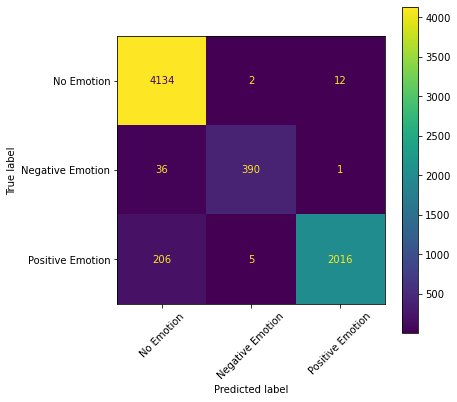

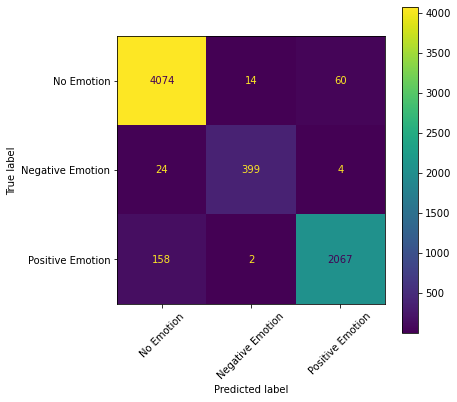

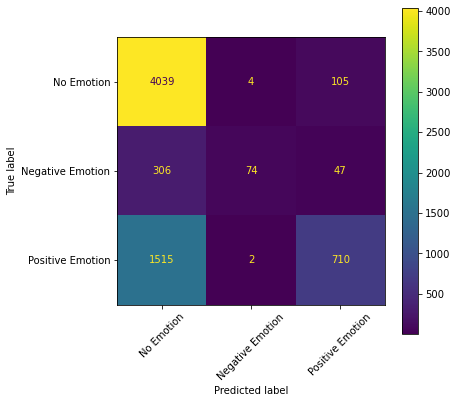

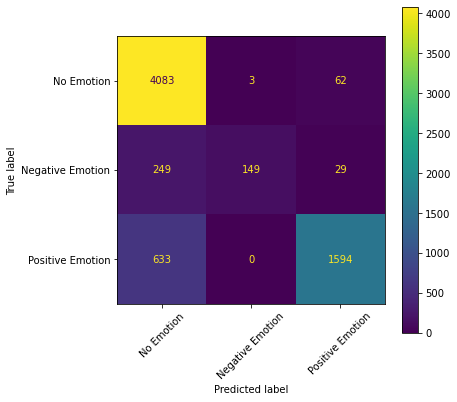

In [88]:
scores = cross_validate_models(models, X_train_clean, y_train_clean, cm=True)

In [90]:
scores

[('MultiNomBa', 0.6734787353589489),
 ('LogisticReg', 0.6871502355534425),
 ('DecTreeClass', 0.6367224575355491),
 ('RandomFor', 0.6765664303928773),
 ('GradBoost', 0.6680392877209663),
 ('SupportVec', 0.6862698275489476)]

## Creating simple models with TFIDF

In [91]:
mnb_tf = Pipeline([('Vectorizer',  TfidfVectorizer(lowercase=False)),
               ('mnb', MultinomialNB())])

lr_tf = Pipeline([('Vectorizer', TfidfVectorizer(lowercase=False)),
               ('LogisticReg', LogisticRegression(max_iter=200, random_state=RANDOM_SEED))])

dtc_tf = Pipeline([('Vectorizer', TfidfVectorizer(lowercase=False)),
               ('DecisionTree', DecisionTreeClassifier(random_state=RANDOM_SEED))])

rf_tf = Pipeline([('Vectorizer', TfidfVectorizer(lowercase=False)),
               ('RandomFor', RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED))]) 

gbc_tf = Pipeline([('Vectorizer', TfidfVectorizer(lowercase=False)),
               ('gradiendboosting', GradientBoostingClassifier(random_state=RANDOM_SEED))])

svc_tf = Pipeline([('Vectorizer', TfidfVectorizer(lowercase=False)),
                ('SupportVec', SVC(random_state=RANDOM_SEED))])

In [92]:
models2 = [('MultiNomBa', mnb_tf),
          ('LogisticReg', lr_tf),
          ('DecTreeClass', dtc_tf),           
          ('RandomFor', rf_tf),
          ('GradBoost', gbc_tf),
          ('SupportVec', svc_tf)]

In [93]:
scores2 = cross_validate_models(models2, X_train_clean, y_train_clean)

In [94]:
scores2

[('MultiNomBa', 0.6555413407096858),
 ('LogisticReg', 0.6852398755240523),
 ('DecTreeClass', 0.6215801530016856),
 ('RandomFor', 0.6768595755715953),
 ('GradBoost', 0.6674525651553789),
 ('SupportVec', 0.6915623244154384)]

## Creating simple models with TFIDF and SMOTE

In [95]:
mnb_sm = imbpipe([('Vectorizer',  TfidfVectorizer(lowercase=False)),
               ('smote', SMOTE(random_state=RANDOM_SEED)),
               ('mnb', MultinomialNB())])

lr_sm = imbpipe([('Vectorizer', TfidfVectorizer(lowercase=False)),
               ('smote', SMOTE(random_state=RANDOM_SEED)),
               ('LogisticReg', LogisticRegression(max_iter=200, random_state=RANDOM_SEED))])

dtc_sm = imbpipe([('Vectorizer', TfidfVectorizer(lowercase=False)),
               ('smote', SMOTE(random_state=RANDOM_SEED)),
               ('DecisionTree', DecisionTreeClassifier(random_state=RANDOM_SEED))])

rf_sm = imbpipe([('Vectorizer', TfidfVectorizer(lowercase=False)),
               ('smote', SMOTE(random_state=RANDOM_SEED)),
               ('RandomFor', RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED))]) 

gbc_sm = imbpipe([('Vectorizer', TfidfVectorizer(lowercase=False)),
               ('smote', SMOTE(random_state=RANDOM_SEED)),
               ('gradiendboosting', GradientBoostingClassifier(random_state=RANDOM_SEED))])

svc_sm = imbpipe([('Vectorizer', TfidfVectorizer(lowercase=False)),
                ('smote', SMOTE(random_state=RANDOM_SEED)),
                ('SupportVec', SVC(random_state=RANDOM_SEED))])

In [96]:
models3 = [('MultiNomBa', mnb_sm),
          ('LogisticReg', lr_sm),
          ('DecTreeClass', dtc_sm),
          ('RandomFor', rf_sm),
          ('GradBoost', gbc_sm),
          ('SupportVec', svc_sm)]

In [97]:
scores3 = cross_validate_models(models3, X_train_clean, y_train_clean)

In [98]:
scores3

[('MultiNomBa', 0.5934994813502182),
 ('LogisticReg', 0.6534833815965768),
 ('DecTreeClass', 0.6218750270130095),
 ('RandomFor', 0.6752446298137182),
 ('GradBoost', 0.6245224099926525),
 ('SupportVec', 0.6849459739810693)]

## Creating simple models with TFIDF and ROS

In [99]:
mnb_ros = imbpipe([('Vectorizer',  TfidfVectorizer(lowercase=False)),
               ('ros',  RandomOverSampler(random_state=RANDOM_SEED)),
               ('mnb', MultinomialNB())])

lr_ros = imbpipe([('Vectorizer', TfidfVectorizer(lowercase=False)),
               ('ros',  RandomOverSampler(random_state=RANDOM_SEED)),
               ('LogisticReg', LogisticRegression(max_iter=200, random_state=RANDOM_SEED))])

dtc_ros = imbpipe([('Vectorizer', TfidfVectorizer(lowercase=False)),
               ('ros',  RandomOverSampler(random_state=RANDOM_SEED)),
               ('DecisionTree', DecisionTreeClassifier(random_state=RANDOM_SEED))])

rf_ros = imbpipe([('Vectorizer', TfidfVectorizer(lowercase=False)),
               ('ros',  RandomOverSampler(random_state=RANDOM_SEED)),
               ('RandomFor', RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED))]) 

gbc_ros = imbpipe([('Vectorizer', TfidfVectorizer(lowercase=False)),
               ('ros',  RandomOverSampler(random_state=RANDOM_SEED)),
               ('gradiendboosting', GradientBoostingClassifier(random_state=RANDOM_SEED))])

svc_ros = imbpipe([('Vectorizer', TfidfVectorizer(lowercase=False)),
               ('ros',  RandomOverSampler(random_state=RANDOM_SEED)),
                ('SupportVec', SVC(random_state=RANDOM_SEED))])

In [100]:
models4 = [('MultiNomBa', mnb_ros),
          ('LogisticReg', lr_ros),
          ('DecTreeClass', dtc_ros),
          ('RandomFor', rf_ros),
          ('GradBoost', gbc_ros),
          ('SupportVec', svc_ros)]

In [101]:
scores4 = cross_validate_models(models4, X_train_clean, y_train_clean)

In [102]:
scores4

[('MultiNomBa', 0.6068797813026754),
 ('LogisticReg', 0.6565710766305053),
 ('DecTreeClass', 0.6004100574836841),
 ('RandomFor', 0.6655397199291178),
 ('GradBoost', 0.5395476941695121),
 ('SupportVec', 0.6884745213294723)]

## Creating simple models with TFIDF with ngram(1,2) and ROS

In [103]:
mnb_gr = imbpipe([('Vectorizer',  TfidfVectorizer(ngram_range = (1,2), lowercase=False)),
               ('ros',  RandomOverSampler(random_state=RANDOM_SEED)),
               ('mnb', MultinomialNB())])

lr_gr = imbpipe([('Vectorizer', TfidfVectorizer(ngram_range = (1,2), lowercase=False)),
               ('ros',  RandomOverSampler(random_state=RANDOM_SEED)),
               ('LogisticReg', LogisticRegression(max_iter=200, random_state=RANDOM_SEED))])

dtc_gr = imbpipe([('Vectorizer', TfidfVectorizer(ngram_range = (1,2), lowercase=False)),
               ('ros',  RandomOverSampler(random_state=RANDOM_SEED)),
               ('DecisionTree', DecisionTreeClassifier(random_state=RANDOM_SEED))])

rf_gr = imbpipe([('Vectorizer', TfidfVectorizer(ngram_range = (1,2), lowercase=False)),
               ('ros',  RandomOverSampler(random_state=RANDOM_SEED)),
               ('RandomFor', RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED))]) 

gbc_gr = imbpipe([('Vectorizer', TfidfVectorizer(ngram_range = (1,2), lowercase=False)),
               ('ros',  RandomOverSampler(random_state=RANDOM_SEED)),
               ('gradiendboosting', GradientBoostingClassifier(random_state=RANDOM_SEED))])

svc_gr = imbpipe([('Vectorizer', TfidfVectorizer(ngram_range = (1,2), lowercase=False)),
               ('ros',  RandomOverSampler(random_state=RANDOM_SEED)),
                ('SupportVec', SVC(random_state=RANDOM_SEED))])

In [104]:
models5 = [('MultiNomBa', mnb_gr),
          ('LogisticReg', lr_gr),
          ('DecTreeClass', dtc_gr),
          ('RandomFor', rf_gr),
          ('GradBoost', gbc_gr),
          ('SupportVec', svc_gr)]

In [105]:
scores5 = cross_validate_models(models5, X_train_clean, y_train_clean)

In [106]:
scores5

[('MultiNomBa', 0.6218745948048581),
 ('LogisticReg', 0.672156826727752),
 ('DecTreeClass', 0.5985009940787483),
 ('RandomFor', 0.6721547737390328),
 ('GradBoost', 0.5642441759951593),
 ('SupportVec', 0.6864155897480225)]

In [107]:
scores4

[('MultiNomBa', 0.6068797813026754),
 ('LogisticReg', 0.6565710766305053),
 ('DecTreeClass', 0.6004100574836841),
 ('RandomFor', 0.6655397199291178),
 ('GradBoost', 0.5395476941695121),
 ('SupportVec', 0.6884745213294723)]

In [108]:
scores3

[('MultiNomBa', 0.5934994813502182),
 ('LogisticReg', 0.6534833815965768),
 ('DecTreeClass', 0.6218750270130095),
 ('RandomFor', 0.6752446298137182),
 ('GradBoost', 0.6245224099926525),
 ('SupportVec', 0.6849459739810693)]

In [109]:
scores2

[('MultiNomBa', 0.6555413407096858),
 ('LogisticReg', 0.6852398755240523),
 ('DecTreeClass', 0.6215801530016856),
 ('RandomFor', 0.6768595755715953),
 ('GradBoost', 0.6674525651553789),
 ('SupportVec', 0.6915623244154384)]

In [110]:
scores

[('MultiNomBa', 0.6734787353589489),
 ('LogisticReg', 0.6871502355534425),
 ('DecTreeClass', 0.6367224575355491),
 ('RandomFor', 0.6765664303928773),
 ('GradBoost', 0.6680392877209663),
 ('SupportVec', 0.6862698275489476)]

### Sample gridsearch

In [774]:
def run_gridsearch(params, name, models, num):
    for model, grid in params.items():
        print(model, 'Grid Search:')
        print(f'Time Started: {time.asctime()}')
        print(model)
        pipe = Pipeline(steps=[('Vectorizer', TfidfVectorizer(lowercase=False)),
                                ('classifier', models[num][1][2])]) 
        
        gridsearch = GridSearchCV(estimator=pipe, param_grid=grid[0], scoring='recall_micro', cv=5)
        gridsearch.fit(X_train_clean, y_train_clean)
        print(f'Time Finished: {time.asctime()}')
        print(f'Cross validation scores: {gridsearch.cv_results_["mean_test_score"]}')
        print(f'Best cross validation score: {gridsearch.best_score_ :.2%}')
        print(f'Optimal parameters: {gridsearch.best_params_}')
        tuned_params[name] = gridsearch.best_params_

In [753]:
num_mba=0
num_lreg=1
num_dtc=2
num_rfc=3
num_gbc=4
num_svc=5

In [760]:
 models[0][1][2]

MultinomialNB()

In [775]:
params_mba1 = {'MultinomialNB': [{
    'classifier__alpha':[.001, .01, .05, .1, .2, .4, .6, .8, 1]
}]}

run_gridsearch(params_mba1, name='MultinomialNB', models=models4, num=num_mba)

MultinomialNB Grid Search:
Time Started: Wed Feb 16 13:00:27 2022
MultinomialNB
Time Finished: Wed Feb 16 13:00:33 2022
Cross validation scores: [0.6681844  0.67215348 0.67803291 0.68023912 0.67994511 0.67832811
 0.67230032 0.66465596 0.66127545]
Best cross validation score: 68.02%
Optimal parameters: {'classifier__alpha': 0.1}


In [776]:
params_lr1 = {'LogisticRegression': [{
    'classifier__C':[0.001, 0.1, 1],
    'classifier__solver':['lbfgs', 'saga'],
    'classifier__fit_intercept':[True, False]
}]}

run_gridsearch(params_lr1, name='LogisticRegression1', models=models4, num=num_lreg)

LogisticRegression Grid Search:
Time Started: Wed Feb 16 13:00:33 2022
LogisticRegression
Time Finished: Wed Feb 16 13:00:52 2022
Cross validation scores: [0.60982063 0.60982063 0.61026159 0.61026159 0.6431924  0.6431924
 0.65701215 0.65701215 0.69420625 0.69420625 0.69729254 0.69729254]
Best cross validation score: 69.73%
Optimal parameters: {'classifier__C': 1, 'classifier__fit_intercept': False, 'classifier__solver': 'lbfgs'}


In [778]:
params_dtc1 = {'DecisionTree': [{
    'classifier__criterion':['gini', 'entropy'],
    'classifier__max_depth':[1, 2, 6, 10, 15],
    'classifier__ccp_alpha':[.001, .01, .1, .5]
}]}

run_gridsearch(params_dtc1, name='DecisionTree1', models=models4, num=num_dtc)

DecisionTree Grid Search:
Time Started: Wed Feb 16 13:07:27 2022
DecisionTree
Time Finished: Wed Feb 16 13:08:03 2022
Cross validation scores: [0.61570299 0.62172797 0.63157734 0.63290001 0.6336353  0.60982063
 0.62011119 0.63510654 0.63451787 0.63348652 0.60982063 0.60982063
 0.60982063 0.60982063 0.60982063 0.60982063 0.61893558 0.61893558
 0.61893558 0.61893558 0.60982063 0.60982063 0.60982063 0.60982063
 0.60982063 0.60982063 0.60982063 0.60982063 0.60982063 0.60982063
 0.60982063 0.60982063 0.60982063 0.60982063 0.60982063 0.60982063
 0.60982063 0.60982063 0.60982063 0.60982063]
Best cross validation score: 63.51%
Optimal parameters: {'classifier__ccp_alpha': 0.001, 'classifier__criterion': 'entropy', 'classifier__max_depth': 6}


In [551]:
params_rf1 = {'RandomForest': [{
    'classifier__n_estimators':[10, 30, 100],
    'classifier__criterion':['gini', 'entropy'],
    'classifier__max_depth':[1, 2, 6, 10],
}]}

run_gridsearch(params_rf1, name='RandomForest1', models=models4, num=num_rfc)

RandomForest Grid Search:
Time Started: Tue Feb 15 19:38:08 2022
RandomForest
Time Finished: Tue Feb 15 19:38:35 2022
Cross validation scores: [0.60982063 0.60982063 0.60982063 0.60982063 0.60982063 0.60982063
 0.61378993 0.6129079  0.61276095 0.61952349 0.61643644 0.61570137
 0.60982063 0.60982063 0.60982063 0.60982063 0.60982063 0.60982063
 0.61217336 0.6112909  0.61246683 0.61481999 0.61481934 0.61437848]
Best cross validation score: 61.95%
Optimal parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__n_estimators': 10}


Takes a long time to run:

In [882]:
# params_gbc1 = {'GradBoostClassifier': [{
#     'classifier__loss':['deviance', 'exponential'],
#     'classifier__learning_rate':[.001, .01, .1],
#     'classifier__n_estimators':[100, 200, 500, 1000],
#     'classifier__max_depth':[1, 2, 5, 10, 15]
# }]}

# run_gridsearch(params_gbc1, name='GradBoostClassifier1', models=models4, num=num_gbc)

In [ ]:
# params_svc1 = {'SVC': [{
#     'classifier__C':[.1, .5, 1, 1.5],
#     'classifier__kernel':['linear', 'poly', 'rbf', 'sigmoid'],
#     'classifier__gamma':['scale', 'auto']
# }]}

# run_gridsearch(params_svc1, name='SVC1', models=models4, num=num_svc)

## Cleaning tweets for presentation

In [851]:
df_sample = df.iloc[2:6]
df_sample2 = df.loc[9092]
df_sample = df_sample.append(df_sample2)

In [852]:
df_sample['text']

2       @swonderlin Can not wait for #iPad 2 also. The...
3       @sxsw I hope this year's festival isn't as cra...
4       @sxtxstate great stuff on Fri #SXSW: Marissa M...
5       @teachntech00 New iPad Apps For #SpeechTherapy...
9092    �ϡ�����_��ʋ�΋�ҋ�������⋁_��������_���RT @mentio...
Name: text, dtype: object

In [853]:
for i in df_sample['text']:
    print(i)

@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.
@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw
@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)
@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd
�ϡ�����_��ʋ�΋�ҋ�������⋁_��������_���RT @mention Google Tests ���Check-in Offers�۝ At #SXSW {link}


In [854]:
df_sample['text'] = df_sample['text'].apply(lambda x: x.lower())

In [855]:
for i in df_sample['text']:
    print(i)

@swonderlin can not wait for #ipad 2 also. they should sale them down at #sxsw.
@sxsw i hope this year's festival isn't as crashy as this year's iphone app. #sxsw
@sxtxstate great stuff on fri #sxsw: marissa mayer (google), tim o'reilly (tech books/conferences) &amp; matt mullenweg (wordpress)
@teachntech00 new ipad apps for #speechtherapy and communication are showcased at the #sxsw conference http://ht.ly/49n4m #iear #edchat #asd
�ϡ�����_��ʋ�΋�ҋ�������⋁_��������_���rt @mention google tests ���check-in offers�۝ at #sxsw {link}


In [856]:
df_sample['text'] = df_sample['text'].str.encode('ascii', 'ignore').str.decode('ascii')

In [857]:
for i in df_sample['text']:
    print(i)

@swonderlin can not wait for #ipad 2 also. they should sale them down at #sxsw.
@sxsw i hope this year's festival isn't as crashy as this year's iphone app. #sxsw
@sxtxstate great stuff on fri #sxsw: marissa mayer (google), tim o'reilly (tech books/conferences) &amp; matt mullenweg (wordpress)
@teachntech00 new ipad apps for #speechtherapy and communication are showcased at the #sxsw conference http://ht.ly/49n4m #iear #edchat #asd
___rt @mention google tests check-in offers at #sxsw {link}


In [858]:
df_sample['text'] = df_sample['text'].apply(lambda x: re.sub(r'http\S+', '', x))

In [859]:
for i in df_sample['text']:
    print(i)

@swonderlin can not wait for #ipad 2 also. they should sale them down at #sxsw.
@sxsw i hope this year's festival isn't as crashy as this year's iphone app. #sxsw
@sxtxstate great stuff on fri #sxsw: marissa mayer (google), tim o'reilly (tech books/conferences) &amp; matt mullenweg (wordpress)
@teachntech00 new ipad apps for #speechtherapy and communication are showcased at the #sxsw conference  #iear #edchat #asd
___rt @mention google tests check-in offers at #sxsw {link}


In [860]:
df_sample['text'] = df_sample['text'].apply(lambda x: re.sub(r'@\S*', '', x))

In [861]:
for i in df_sample['text']:
    print(i)

 can not wait for #ipad 2 also. they should sale them down at #sxsw.
 i hope this year's festival isn't as crashy as this year's iphone app. #sxsw
 great stuff on fri #sxsw: marissa mayer (google), tim o'reilly (tech books/conferences) &amp; matt mullenweg (wordpress)
 new ipad apps for #speechtherapy and communication are showcased at the #sxsw conference  #iear #edchat #asd
___rt  google tests check-in offers at #sxsw {link}


In [862]:
df_sample['text'] = df_sample['text'].apply(lambda x: tokenize_row(x))

In [863]:
for i in df_sample['text']:
    print(i)

['', 'can', 'not', 'wait', 'for', 'ipad', '2', 'also', 'they', 'should', 'sale', 'them', 'down', 'at', 'sxsw', '']
['', 'i', 'hope', 'this', 'year', 's', 'festival', 'isn', 't', 'as', 'crashy', 'as', 'this', 'year', 's', 'iphone', 'app', 'sxsw']
['', 'great', 'stuff', 'on', 'fri', 'sxsw', 'marissa', 'mayer', 'google', 'tim', 'o', 'reilly', 'tech', 'books', 'conferences', 'amp', 'matt', 'mullenweg', 'wordpress', '']
['', 'new', 'ipad', 'apps', 'for', 'speechtherapy', 'and', 'communication', 'are', 'showcased', 'at', 'the', 'sxsw', 'conference', 'iear', 'edchat', 'asd']
['___rt', 'google', 'tests', 'check', 'in', 'offers', 'at', 'sxsw', 'link', '']


In [864]:
df_sample['text'] = df_sample['text'].apply(lambda x: remove_punctuation_row(x))

In [865]:
for i in df_sample['text']:
    print(i)

['can', 'not', 'wait', 'for', 'ipad', '2', 'also', 'they', 'should', 'sale', 'them', 'down', 'at', 'sxsw']
['i', 'hope', 'this', 'year', 's', 'festival', 'isn', 't', 'as', 'crashy', 'as', 'this', 'year', 's', 'iphone', 'app', 'sxsw']
['great', 'stuff', 'on', 'fri', 'sxsw', 'marissa', 'mayer', 'google', 'tim', 'o', 'reilly', 'tech', 'books', 'conferences', 'amp', 'matt', 'mullenweg', 'wordpress']
['new', 'ipad', 'apps', 'for', 'speechtherapy', 'and', 'communication', 'are', 'showcased', 'at', 'the', 'sxsw', 'conference', 'iear', 'edchat', 'asd']
['rt', 'google', 'tests', 'check', 'in', 'offers', 'at', 'sxsw', 'link']


In [866]:
df_sample['text'] = df_sample['text'].apply(lambda x: remove_stopwords_row(x))

In [867]:
for i in df_sample['text']:
    print(i)

['not', 'wait', 'ipad', '2', 'also', 'sale', 'sxsw']
['hope', 'year', 'festival', 'crashy', 'year', 'iphone', 'app', 'sxsw']
['great', 'stuff', 'fri', 'sxsw', 'marissa', 'mayer', 'google', 'tim', 'reilly', 'tech', 'books', 'conferences', 'amp', 'matt', 'mullenweg', 'wordpress']
['new', 'ipad', 'apps', 'speechtherapy', 'communication', 'showcased', 'sxsw', 'conference', 'iear', 'edchat', 'asd']
['google', 'tests', 'check', 'offers', 'sxsw', 'link']


In [868]:
df_sample['text'] = df_sample['text'].apply(lambda x: lem_row(x))

In [869]:
for i in df_sample['text']:
    print(i)

['not', 'wait', 'ipad', '2', 'also', 'sale', 'sxsw']
['hope', 'year', 'festival', 'crashy', 'year', 'iphone', 'app', 'sxsw']
['great', 'stuff', 'fri', 'sxsw', 'marissa', 'mayer', 'google', 'tim', 'reilly', 'tech', 'book', 'conference', 'amp', 'matt', 'mullenweg', 'wordpress']
['new', 'ipad', 'apps', 'speechtherapy', 'communication', 'showcased', 'sxsw', 'conference', 'iear', 'edchat', 'asd']
['google', 'test', 'check', 'offer', 'sxsw', 'link']


In [870]:
more_stop_words_r = ['link', 'also', 'sxsw', 'amp', ]

In [873]:
def remove_stopwords_row2(text):
    text=[word for word in text if word not in more_stop_words_r]
    return text

In [874]:
df_sample['text'] = df_sample['text'].apply(lambda x: remove_stopwords_row2(x))

In [875]:
for i in df_sample['text']:
    print(i)

['not', 'wait', 'ipad', '2', 'sale']
['hope', 'year', 'festival', 'crashy', 'year', 'iphone', 'app']
['great', 'stuff', 'fri', 'marissa', 'mayer', 'google', 'tim', 'reilly', 'tech', 'book', 'conference', 'matt', 'mullenweg', 'wordpress']
['new', 'ipad', 'apps', 'speechtherapy', 'communication', 'showcased', 'conference', 'iear', 'edchat', 'asd']
['google', 'test', 'check', 'offer']


In [876]:
df_sample['text'] = df_sample['text'].apply(lambda x: ' '.join(x))

In [877]:
for i in df_sample['text']:
    print(i)

not wait ipad 2 sale
hope year festival crashy year iphone app
great stuff fri marissa mayer google tim reilly tech book conference matt mullenweg wordpress
new ipad apps speechtherapy communication showcased conference iear edchat asd
google test check offer


# Vectorizing

In [116]:
df_clean = pd.concat([df_train_clean, df_test_clean], axis=0)

### Using CV

Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

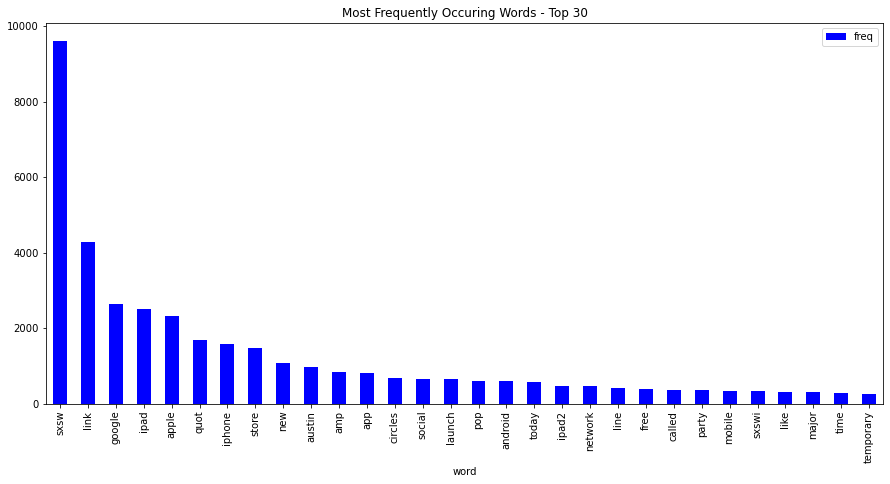

In [119]:
cv = CountVectorizer(stop_words = 'english', lowercase=False)

words = cv.fit_transform(df_clean.text)

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 30")

### Using TFIDF

Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

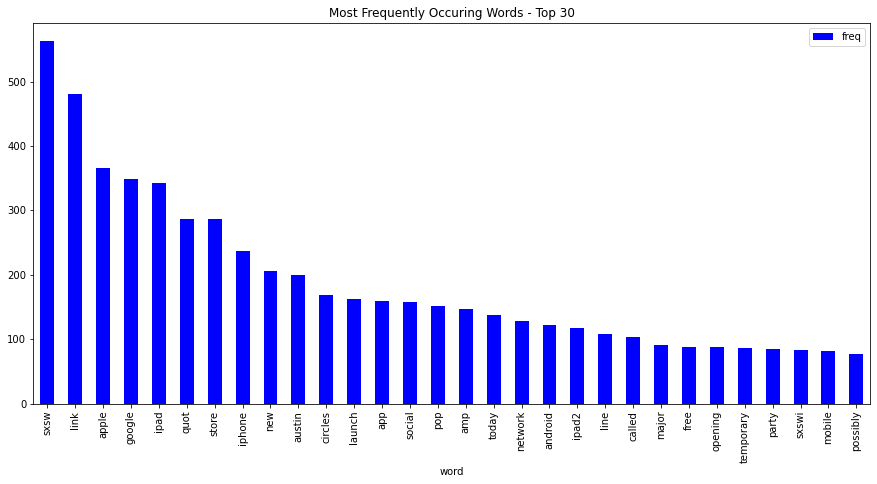

In [120]:
tfidf = TfidfVectorizer(stop_words = 'english', lowercase=False)

words = tfidf.fit_transform(df_clean.text)

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in tfidf.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 30")

### Using TFIDF and removing more stopwords

In [121]:
even_more_sw = ['sxsw', 'link', 'apple', 'ipad', 'google', 'store', 'quot', 'iphone', 'austin', 'app', 'ipad2', 'android', 'pop', 'amp']

Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

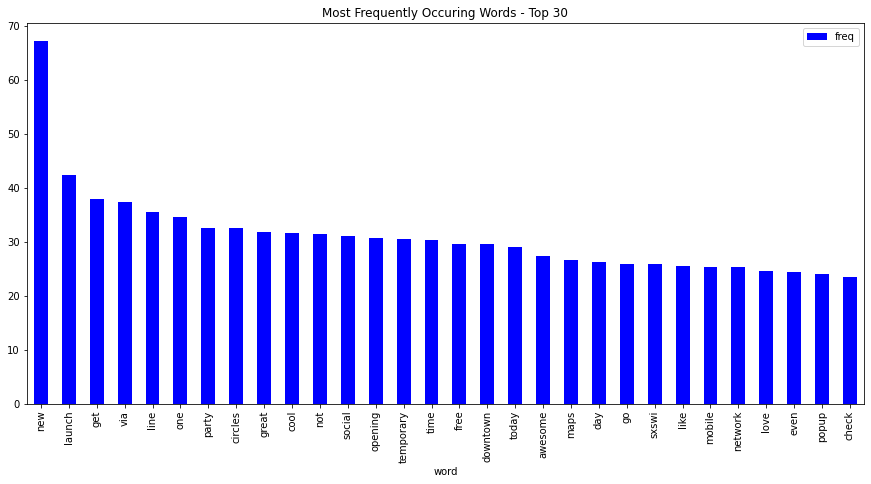

In [122]:
tfidf = TfidfVectorizer(stop_words=even_more_sw, lowercase=False)

words = tfidf.fit_transform(df_clean[df_clean['target']==2]['text'])

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in tfidf.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 30")

# Generating Wordclouds

### All data cloud

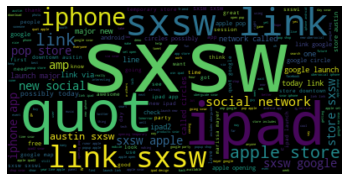

In [148]:
text = ' '.join(df_clean.text)

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Positive tweets cloud

In [152]:
df_good = df_clean.copy()
df_good = df_good[df_good['target']==2]
text_good = ' '.join(df_good.text)

In [161]:
more_stopwords = ['sxsw','sxswi', 'link', 'quot']

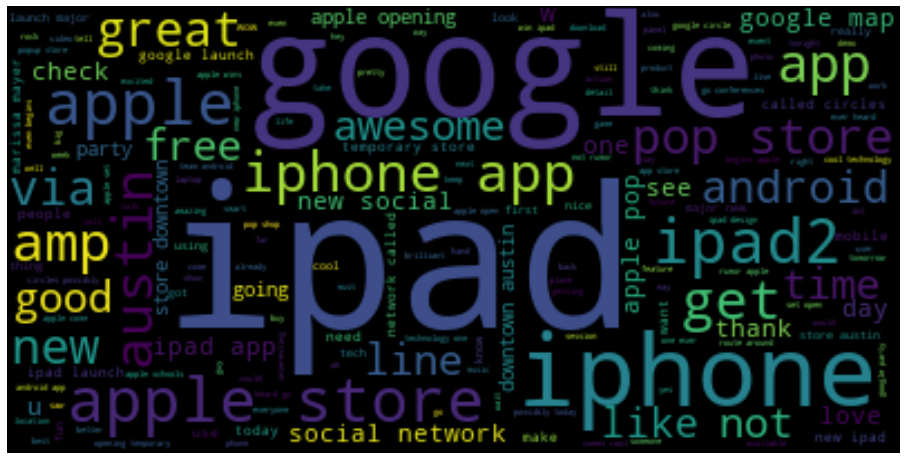

In [162]:
wordcloud = WordCloud(stopwords=more_stopwords).generate(text_good)

plt.figure(figsize=(16,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Negative tweets cloud

In [158]:
df_bad = df_clean.copy()
df_bad = df_bad[df_bad['target']==1]
text_bad = ' '.join(df_bad.text)

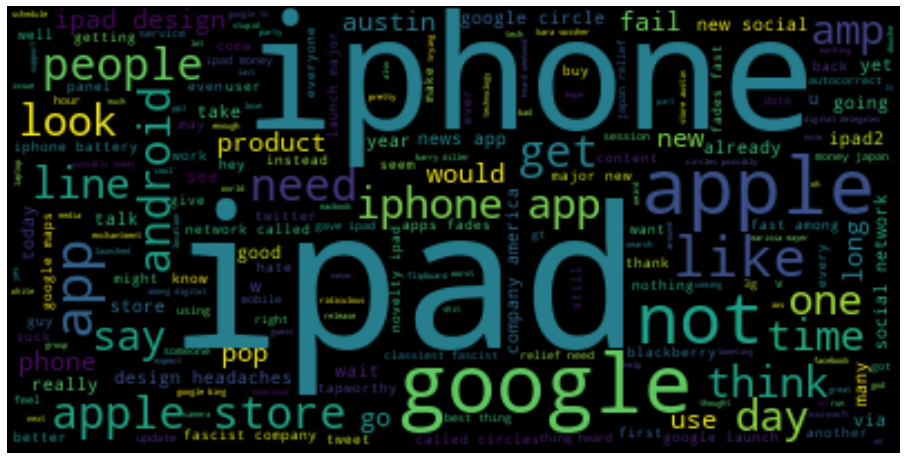

In [164]:
wordcloud = WordCloud(stopwords=more_stopwords).generate(text_bad)

plt.figure(figsize=(16,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Neutral tweets cloud

In [165]:
df_neutral = df_clean.copy()
df_neutral = df_neutral[df_neutral['target']==0]
text_neutral = ' '.join(df_neutral.text)

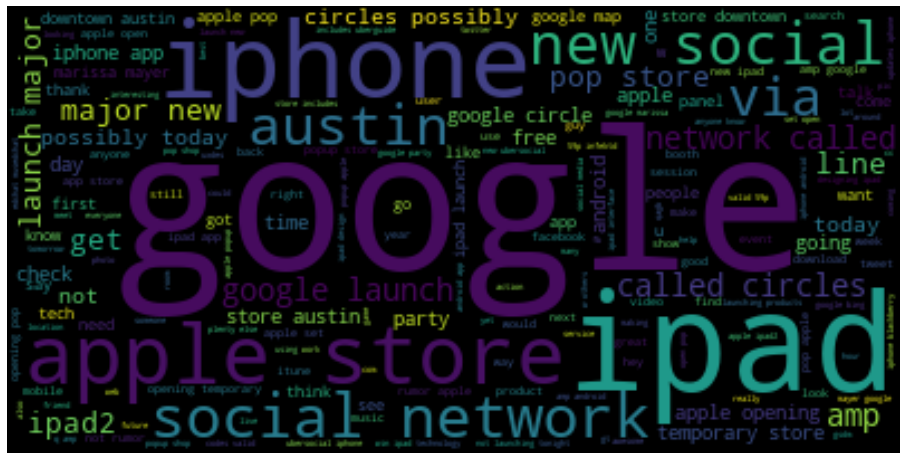

In [166]:
wordcloud = WordCloud(stopwords=more_stopwords).generate(text_neutral)

plt.figure(figsize=(16,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()